# Fotografía del Mercado Inmobiliario en la comuna de Santiago:
## Factores Clave en el Precio de Departamentos


#### Autor: Ricardo Urdaneta

Fecha: 24 julio 2025

El mercado inmobiliario en Santiago es un sector dinámico y de alto interés tanto para inversionistas como para futuros propietarios. Comprender las variables que determinan el valor de una propiedad es fundamental para tomar decisiones informadas. Este análisis se sumerge en el mercado de venta de departamentos en la comuna de Santiago, utilizando datos extraídos mediante técnicas de web scraping desde el portal Mercado Libre durante el día 26 de julio de 2025.

El objetivo es transformar datos en bruto y desestructurados en un conjunto de datos limpio y accionable, que nos permita descubrir patrones, tendencias y las relaciones clave que definen el panorama inmobiliario actual.

#### Objetivo del Análisis
El objetivo principal de este proyecto es identificar y cuantificar los factores que más influyen en el precio de venta de los departamentos en Santiago. A través de un análisis exploratorio de datos (EDA), se buscará caracterizar la oferta actual y entender la relación entre el precio y las características de las propiedades.


#### Metodología
Para alcanzar el objetivo, se seguirá un proceso estructurado que abarca el ciclo de vida completo de un proyecto de datos:

`Extracción de Datos`: Obtención de datos crudos mediante web scraping y ya realizado en la **parte 1**.

`Limpieza y Preprocesamiento (ETL)`: Transformación de los datos brutos en un formato estructurado y limpio, manejando valores nulos y creando nuevas variables.

`Análisis Exploratorio de Datos (EDA)`: Cálculo de estadísticas, identificación de patrones y relaciones a través de visualizaciones.

`Interpretación de Resultados`: Obtención de conclusiones claras y respuestas a las preguntas clave planteadas.

### Preparamos el ambiente

Importamos las librerias con las que trabajaremos.

In [81]:
# Importamos las librerías principales
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

Debido a la naturaleza de los datos crudos del archivo .csv obtenido a través de web scraping, no se puede utilizar el método `.read_csv()` sino que se tuvo que hacer una lectura manual como un simple archivo de texto para luego construir el dataframe manualmente.

Este código abre el archivo, lee cada línea una por una y las guarda en una lista. Finalmente, crea el DataFrame a partir de esa lista.

In [82]:
# Definimos la ruta del archivo
ruta_archivo = 'data/datos_raw_inmuebles_santiago.csv'

# Creamos una lista vacía para guardar cada línea de datos
lista_de_datos = []

print("Intentando cargar el archivo línea por línea...")

try:
    # Abrimos el archivo en modo lectura ('r') con la codificación correcta
    with open(ruta_archivo, 'r', encoding='utf-8-sig') as f:
        
        # Saltamos la primera línea, que es el encabezado 'datos_brutos'
        next(f)
        
        # Leemos cada línea restante del archivo
        for linea in f:
            # Añadimos la línea a nuestra lista, quitando espacios o saltos de línea al principio y al final (.strip())
            lista_de_datos.append(linea.strip())

    # Creamos el DataFrame a partir de la lista que llenamos
    df = pd.DataFrame(lista_de_datos, columns=['datos_brutos'])

    # --- Verificación Final ---
    print("\n¡Éxito! El archivo se cargó correctamente.")
    print(f"Se cargaron {len(df)} registros.")
    df.head()
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en la ruta '{ruta_archivo}'")
except Exception as e:
    print(f"Ocurrió un error inesperado durante la lectura del archivo: {e}")
df.head()

Intentando cargar el archivo línea por línea...

¡Éxito! El archivo se cargó correctamente.
Se cargaron 2016 registros.


,datos_brutos
0,PROYECTO | Departamentos en venta | Edificio C...
1,PROYECTO | Departamentos en venta | San Ignaci...
2,PROYECTO | Departamentos en venta | Sinergía V...
3,PROYECTO | Departamentos en venta | Jofre | UF...
4,PROYECTO | Departamentos en venta | Eco Espaci...


#### Data Wrangling

Transformamos la columna de texto `datos_brutos` en un DataFrame estructurado, utilizando las expresiones regulares `regex`.

#### Proceso:

* Extracción de Características: Se crean nuevas columnas para `Moneda`, `Precio`, `Dormitorios`, `Banos`, `Superficie_m2`, `Direccion` y `Comuna`. Cada una extrae su dato correspondiente del texto original buscando patrones específicos (ej. un número seguido de "dorms." o el símbolo "UF").

* Limpieza y Conversión: Los datos extraídos, que inicialmente son texto, se limpian (ej. quitando puntos de los miles en el precio) y se convierten al tipo de dato numérico adecuado para permitir cálculos matemáticos.

* DataFrame Final: Se genera un nuevo DataFrame llamado `df_limpio` que contiene únicamente las columnas limpias y estructuradas, casi listo para el análisis exploratorio.

In [83]:
#  Extraer Moneda y Precio 

# Usamos un regex que busca el patrón "| UF | número |" o "| $ | número |" y captura la moneda y el número.
df[['Moneda', 'Precio_str']] = df['datos_brutos'].str.extract(r'\|\s*(UF|\$)\s*\|\s*([\d\.]+)', expand=True)


# Limpiamos la columna de precio: quitamos los puntos y la convertimos a tipo numérico.
df['Precio'] = pd.to_numeric(df['Precio_str'].str.replace('.', '', regex=False), errors='coerce')

# Asignamos el tipo Int64 que permite valores nulos (NaN)
df['Precio'] = df['Precio'].astype('Int64')

# Verificamos las primeras 5 filas de las columnas extraídas para confirmar el éxito
print("Verificación de Moneda y Precio extraídos:")
print(df[['Moneda', 'Precio']].head())


#  Extraer Dormitorios 

# Buscamos un número seguido de la palabra "dorm" o "dormitorio(s)". El regex (\d+) captura uno o más dígitos.
df['Dormitorios'] = df['datos_brutos'].str.extract(r'(\d+)\s*dorms?|(\d+)\s*dormitorio?s?').bfill(axis=1)[0]
# Convertimos a tipo numérico. Int64 (con mayúscula) permite valores nulos (NaN).
df['Dormitorios'] = pd.to_numeric(df['Dormitorios'], errors='coerce').astype('Int64')


# Extraer Baños 

# Buscamos un número seguido de la palabra "baño(s)".
df['Banos'] = df['datos_brutos'].str.extract(r'(\d+)\s*baños?', expand=False)
# Convertimos a tipo numérico nullable.
df['Banos'] = pd.to_numeric(df['Banos'], errors='coerce').astype('Int64')


#  Extraer Superficie 

# Buscamos un número que pueda tener decimales seguido de "m²". Capturamos solo el primer número si hay un rango (ej. "22-31 m²").
df['Superficie_m2'] = df['datos_brutos'].str.extract(r'([\d\.]+)(?:-[\d\.]+)?\s*m²', expand=False)
# Convertimos a tipo numérico.
df['Superficie_m2'] = pd.to_numeric(df['Superficie_m2'], errors='coerce')


#  Extraer Dirección y Comuna 

# Asumimos una estructura como "Calle 123, Comuna, RM". El regex captura los dos textos separados por una coma antes de "RM".
df[['Direccion', 'Comuna']] = df['datos_brutos'].str.extract(r'([^,]+),\s*([^,]+),\s*RM', expand=True)
# Limpiamos espacios en blanco al inicio o final que pudieran quedar.
if 'Direccion' in df.columns:
    df['Direccion'] = df['Direccion'].str.strip()
if 'Comuna' in df.columns:
    df['Comuna'] = df['Comuna'].str.strip()


# Creación del DataFrame Final y Verificación 

# Seleccionamos solo las columnas que creamos, en el orden deseado.
columnas_finales = ['Moneda', 'Precio', 'Dormitorios', 'Banos', 'Superficie_m2', 'Direccion', 'Comuna']
df_limpio = df[columnas_finales].copy()

# Usamos .info() para ver un resumen del DataFrame
print("--- Información del DataFrame Limpio ---")
df_limpio.info()

# Mostramos las primeras filas del resultado final.
print("\n--- Vista Previa del DataFrame Limpio ---")
df_limpio.head()

Verificación de Moneda y Precio extraídos:
  Moneda  Precio
0     UF    2516
1     UF    2245
2     UF    2160
3     UF    3092
4     UF    2630
--- Información del DataFrame Limpio ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Moneda         2015 non-null   object 
 1   Precio         2015 non-null   Int64  
 2   Dormitorios    2006 non-null   Int64  
 3   Banos          2010 non-null   Int64  
 4   Superficie_m2  2013 non-null   float64
 5   Direccion      2015 non-null   object 
 6   Comuna         2015 non-null   object 
dtypes: Int64(3), float64(1), object(3)
memory usage: 116.3+ KB

--- Vista Previa del DataFrame Limpio ---


,Moneda,Precio,Dormitorios,Banos,Superficie_m2,Direccion,Comuna
0,UF,2516,2,2,53.0,Bulnes,Santiago
1,UF,2245,2,2,52.0,Dieciocho,Santiago
2,UF,2160,2,2,62.0,Bogotá - Sierra Bella,Santiago
3,UF,3092,1,1,32.0,Santa Isabel,Santiago
4,UF,2630,2,2,63.0,Santa Isabel,Santiago


Convertimos el índice del DataFrame en una nueva columna llamada `id`

In [84]:
# Convierte el índice actual del DataFrame 'df_limpio' en una nueva columna llamada 'index'
df_limpio.reset_index(inplace=True)

# Renombramos esa nueva columna de 'index' a 'id' para que sea más claro
df_limpio.rename(columns={'index': 'id'}, inplace=True)

# Mostramos las primeras filas para verificar que la nueva columna 'id' fue creada correctamente
df_limpio.head()

,id,Moneda,Precio,Dormitorios,Banos,Superficie_m2,Direccion,Comuna
0,0,UF,2516,2,2,53.0,Bulnes,Santiago
1,1,UF,2245,2,2,52.0,Dieciocho,Santiago
2,2,UF,2160,2,2,62.0,Bogotá - Sierra Bella,Santiago
3,3,UF,3092,1,1,32.0,Santa Isabel,Santiago
4,4,UF,2630,2,2,63.0,Santa Isabel,Santiago


In [85]:
# Establecemos la columna 'id' como el nuevo índice del DataFrame.
# El índice anterior (0, 1, 2...) será reemplazado.
df_limpio.set_index('id', inplace=True)

# Mostramos el resultado final. Verás que 'id' ahora ocupa el lugar del índice.
df_limpio.head()

,Moneda,Precio,Dormitorios,Banos,Superficie_m2,Direccion,Comuna
id,,,,,,,
0,UF,2516,2,2,53.0,Bulnes,Santiago
1,UF,2245,2,2,52.0,Dieciocho,Santiago
2,UF,2160,2,2,62.0,Bogotá - Sierra Bella,Santiago
3,UF,3092,1,1,32.0,Santa Isabel,Santiago
4,UF,2630,2,2,63.0,Santa Isabel,Santiago


#### Guardamos el DataFame parcialmente limpio

In [86]:
# Definir la carpeta y el nombre del archivo final
carpeta_salida = 'data'
nombre_archivo = 'datos_limpios_inmuebles.csv'
ruta_completa = os.path.join(carpeta_salida, nombre_archivo)

# Crear la carpeta 'data' si no existe para evitar errores
os.makedirs(carpeta_salida, exist_ok=True)

# Guardar el DataFrame en la ruta especificada
# El DataFrame se guarda con el índice, que ahora es tu columna 'id'.
df_limpio.to_csv(ruta_completa, encoding='utf-8-sig')

print(f"DataFrame guardado en: {ruta_completa}")

DataFrame guardado en: data\datos_limpios_inmuebles.csv


En este caso, no haremos un analisis geográfico, por ende eliminaremos las columnas `Direccion` y `Comuna`

In [87]:
# Lista de las columnas que no necesitamos
columnas_a_eliminar = ['Direccion', 'Comuna']

# Método .drop() para eliminarlas del DataFrame
df_limpio.drop(columns=columnas_a_eliminar, axis=1, inplace=True) # axis=1 indica a Pandas que estamos eliminando columnas # inplace=True modifica df_limpio

# Verificamos el resultado mostrando las primeras 5 filas. Las columnas 'Direccion' y 'Comuna' no deberían aparecer.
df_limpio.head()

,Moneda,Precio,Dormitorios,Banos,Superficie_m2
id,,,,,
0,UF,2516,2,2,53.0
1,UF,2245,2,2,52.0
2,UF,2160,2,2,62.0
3,UF,3092,1,1,32.0
4,UF,2630,2,2,63.0


#### Unificar valores de `Moneda`

Al haber hecho una inspeccion preliminar a la página web de Mercadolibre, vimos que habían dos tipos de valores: `UF` y `$`.

Verificamos que estemos en lo correcto.

In [88]:
# Contamos la frecuencia de cada valor en la columna 'Moneda'
conteo_moneda = df_limpio['Moneda'].value_counts()

# Imprimimos el resultado
print(conteo_moneda)

Moneda
UF    1785
$      230
Name: count, dtype: int64


Convertirimos los registros que estan en `$` a `UF` asignando el valor `UF = 39209.42` (al 26 de julio del 2025) y diviendolo por los registros que están en `$`, redondeando el resultado.

In [89]:
# Definimos el valor de la UF que usaremos para la conversión
valor_uf = 39209.42

# Seleccionamos las filas que tienen precios en pesos chilenos ('$')
filas_a_convertir = df_limpio['Moneda'] == '$' # Esto crea una máscara booleana (True/False) para identificar las filas a convertir

# Aplicamos la conversión solo a las filas seleccionadas
df_limpio.loc[filas_a_convertir, 'Precio'] = (df_limpio.loc[filas_a_convertir, 'Precio'] / valor_uf).round() # Dividimos el 'Precio' por el valor de la UF y lo redondeamos

# Actualizamos la columna 'Moneda' a 'UF' en las filas que acabamos de convertir
df_limpio.loc[filas_a_convertir, 'Moneda'] = 'UF'

# Aseguramos que la columna 'Precio' mantenga el tipo de dato correcto (Int64)
df_limpio['Precio'] = df_limpio['Precio'].astype('Int64') # El tipo 'Int64' (con I mayúscula) permite números enteros y valores nulos (NaN)

# Verificación
print("--- Verificación de Moneda después de la conversión ---")
# Ahora solo debería aparecer 'UF' (y NaN si hay valores nulos)
print(df_limpio['Moneda'].value_counts(dropna=False))

--- Verificación de Moneda después de la conversión ---
Moneda
UF     2015
NaN       1
Name: count, dtype: int64


#### Busqueda de valores nulos 

Usamos la funcion `isnull().sum()` para ver la totalidad de valores nulos.

In [90]:
# Muestra totalidad de valores nulos
df_limpio.isnull().sum()

Moneda            1
Precio            1
Dormitorios      10
Banos             6
Superficie_m2     3
dtype: int64

En este caso, al tratarse de pocos valores nulos respecto a la proporcionalidad de los datos, no los eliminaremos ya que queremos usar todos los datos extraídos posibles. No aplicaremos el método de cambiarlos por el valor promedio sino que aplicaremos el uso de la mediana.

In [91]:
# Hacemos una copia del DataFrame para trabajar sobre ella y mantener el original si es necesario
df_final = df_limpio.copy()

# Lista de columnas numéricas en las que queremos rellenar los nulos
columnas_numericas = ['Precio', 'Dormitorios', 'Banos', 'Superficie_m2']

# Iteramos sobre cada columna de la lista
for columna in columnas_numericas:
    # 1. Calculamos la mediana de la columna actual
    mediana = df_final[columna].median()
    
    # 2. Rellenamos los valores nulos (NaN) de esa columna con la mediana calculada
    df_final[columna].fillna(mediana, inplace=True)
    
    # 3. Opcional: convertimos las columnas que deben ser enteras de vuelta a tipo entero
    if columna in ['Precio', 'Dormitorios', 'Banos']:
        # Ahora que no hay nulos, podemos usar 'int' de forma segura
        df_final[columna] = df_final[columna].astype(int)

# Verificación
# Comprobamos de nuevo el conteo de nulos. Las columnas numéricas deberían aparecer con 0.
print("--- Conteo de Nulos Después de Rellenar ---")
print(df_final.isnull().sum())

print("\n--- Vista Previa del DataFrame Final ---")
df_final.head()

--- Conteo de Nulos Después de Rellenar ---
Moneda           1
Precio           0
Dormitorios      0
Banos            0
Superficie_m2    0
dtype: int64

--- Vista Previa del DataFrame Final ---


,Moneda,Precio,Dormitorios,Banos,Superficie_m2
id,,,,,
0,UF,2516,2,2,53.0
1,UF,2245,2,2,52.0
2,UF,2160,2,2,62.0
3,UF,3092,1,1,32.0
4,UF,2630,2,2,63.0


Eliminamos por ultimo la columna Moneda usando la función `.drop` solo para trabajar con datos numéricos.

In [92]:
# Eliminamos la columna 'Moneda' del DataFrame
df_final.drop('Moneda', axis=1, inplace=True)

In [93]:
# Verificamos el resultado mostrando las primeras filas del DataFrame actualizado
df_final.head()

,Precio,Dormitorios,Banos,Superficie_m2
id,,,,
0,2516,2,2,53.0
1,2245,2,2,52.0
2,2160,2,2,62.0
3,3092,1,1,32.0
4,2630,2,2,63.0


Hacemos una inspeccion final revisando las estadisticas descriptivas mediante la funcion `.describe()`

In [94]:
df_final.describe()

,Precio,Dormitorios,Banos,Superficie_m2
count,2016.000000,2016.000000,2016.000000,2016.000000
mean,2809.600694,1.766369,1.430556,49.930641
std,1951.995048,1.238938,0.667679,37.881130
min,383.000000,1.000000,1.000000,2.000000
25%,1947.500000,1.000000,1.000000,33.000000
50%,2450.000000,2.000000,1.000000,43.000000
75%,3090.000000,2.000000,2.000000,55.000000
max,27000.000000,37.000000,15.000000,651.000000


A simple vista llaman la atención el valor máximo en `Precio` (27000) considerando que el promedio es de 2809.60, y el mínimo (383).

Los investigaremos para verficiar si pueden tratarse o no de un error.

#### Valores atípicos

#### Detección de valores atípicos máximos en Precio
Lo haremos mediante dos figuras, la primera con un gráfico boxplot para tener una idea visual de los valores atípicos y la segunda con una tabla mostrando los valores que superan el límite superior del rango intercuartílico.

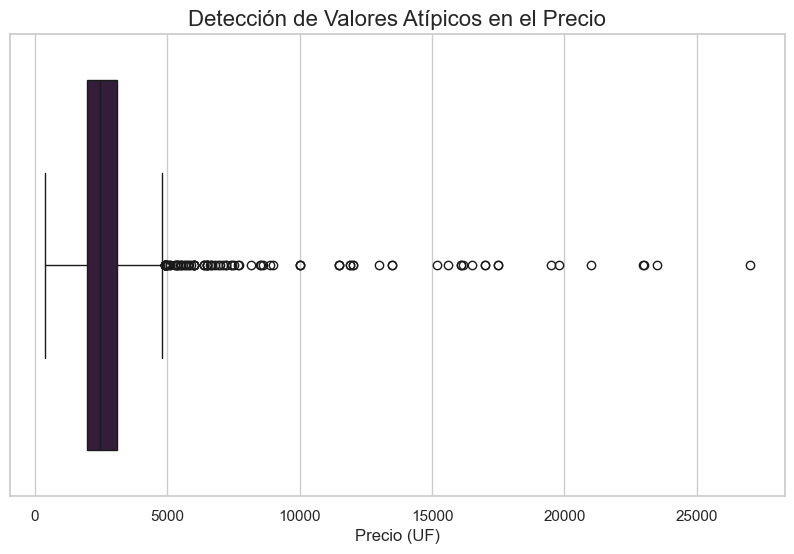

In [95]:
# Configuramos el estilo y tamaño del gráfico
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Creamos un box plot para la columna 'Precio'
sns.boxplot(x=df_final['Precio'])

# Añadimos títulos y etiquetas
plt.title('Detección de Valores Atípicos en el Precio', fontsize=16)
plt.xlabel('Precio (UF)', fontsize=12)

# Mostramos el gráfico
plt.show()

In [96]:
# Calculamos los cuartiles y el rango intercuartílico (IQR) para la columna 'Precio'
Q1 = df_final['Precio'].quantile(0.25)
Q3 = df_final['Precio'].quantile(0.75)
IQR = Q3 - Q1

# Definimos el límite superior. Cualquier valor por encima de este es un outlier.
limite_superior = Q3 + 1.5 * IQR

print(f"Límite superior para ser considerado un outlier de precio: {limite_superior:,.0f} UF")

# Filtramos el DataFrame para mostrar solo las filas cuyo precio supera este límite
valores_atipicos_precio = df_final[df_final['Precio'] > limite_superior]

# Mostramos los valores atípicos, ordenados del más caro al más barato
print("\n--- Departamentos con Precios Atípicos (Extremos) ---")
print(valores_atipicos_precio.sort_values('Precio', ascending=False))

Límite superior para ser considerado un outlier de precio: 4,804 UF

--- Departamentos con Precios Atípicos (Extremos) ---
      Precio  Dormitorios  Banos  Superficie_m2
id                                             
1128   27000            2      1           43.0
1633   23500            4      3          325.0
1767   23000            3      4          300.0
893    22950           37     15          626.0
1637   21000            3      2          280.0
...      ...          ...    ...            ...
1044    4900            3      2           75.0
1229    4900            3      1           85.0
1198    4900            2      2           60.0
1086    4900            3      2           80.0
1648    4900            2      2           74.0

[92 rows x 4 columns]


Solo el departamento `id 1128` muestra lo que podría ser un error ya que no es coherente el `Precio` respecto a `Superficie_m2` entonces lo eliminamos.

In [97]:
# Definimos el ID de la fila que queremos eliminar
id_eliminar = 1128

# Usamos .drop() para eliminar la fila usando su índice. 
# inplace=True modifica el DataFrame df_final directamente.
# errors='ignore' evita que el código falle si intentas eliminar una fila que ya no existe.
df_final.drop(id_eliminar, inplace=True, errors='ignore')

# Confirmamos que la fila fue eliminada imprimiendo un mensaje
print(f"Fila con id {id_eliminar} eliminada.")

Fila con id 1128 eliminada.


#### Busqueda de valores atípicos mínimos en Superficie_m2
Esta vez edtectaremos los valores atípicos mínimos ordenando el DataFrame por `Superficie_m2` de menor a mayor.


In [98]:
# Ordenamos el DataFrame por 'Superficie_m2' de menor a mayor
df_final.sort_values(by='Superficie_m2', ascending=True).head(30)

,Precio,Dormitorios,Banos,Superficie_m2
id,,,,
79,2190,1,1,2.000
1371,3400,1,1,2.000
336,4000,2,2,2.000
1250,4000,3,2,3.000
1298,2200,1,1,3.000
1275,3700,2,2,3.000
1142,2780,2,2,3.000
1340,3762,2,2,4.447
1367,1900,1,1,5.000


Por lógica de analisis, eliminaremos las primeras 20 filas con menor número de superificie_m2 ya que no es repesentativo de la realidad en la capital. No es común encontrar departamentos de menos de 20 m2.

In [99]:
# Guardamos el número de filas antes de eliminar para verificar
conteo_original = len(df_final)

# Identificamos los índices de las 20 propiedades más pequeñas
indices_a_eliminar = df_final.sort_values(by='Superficie_m2', ascending=True).head(20).index

# Eliminamos esas filas del DataFrame usando sus índices
df_final.drop(indices_a_eliminar, inplace=True)

# Imprimimos un resumen de la operación
print(f"Se eliminaron {len(indices_a_eliminar)} filas.")
print(f"Número de filas original: {conteo_original}")
print(f"Número de filas actual: {len(df_final)}")

# Verificamos la nueva superficie mínima
print(f"Nueva superficie mínima: {df_final['Superficie_m2'].min()} m²")

Se eliminaron 20 filas.
Número de filas original: 2015
Número de filas actual: 1995
Nueva superficie mínima: 19.0 m²


---

#### Análisis exploratorio de datos

#### ¿Cuál es el valor promedio del metro cuadrado en Santiago?

Para un mejor analisis en general, enriqueceremos nuesto DataFrame creando una nueva columna `Precio_por_m2` que contenga una formula sencilla tomando el `Precio` y diviendiendo por `Superficie_m2`

* Creación de la Columna `Precio_por_m2`:

In [100]:
# Creamos la nueva columna 'precio_por_m2' dividiendo el Precio por la Superficie
df_final['Precio_por_m2'] = df_final['Precio'] / df_final['Superficie_m2']

# Verificamos el resultado mostrando las primeras filas, ahora con la nueva columna
df_final.head()

,Precio,Dormitorios,Banos,Superficie_m2,Precio_por_m2
id,,,,,
0,2516,2,2,53.0,47.471698
1,2245,2,2,52.0,43.173077
2,2160,2,2,62.0,34.838710
3,3092,1,1,32.0,96.625000
4,2630,2,2,63.0,41.746032


Ahora que tenemos la columna, podemos responder cuál es su valor promedio con la función `.mean`

In [101]:
# Calculamos el valor promedio del metro cuadrado
valor_promedio_m2 = df_final['Precio_por_m2'].mean()
print(f"El valor promedio del metro cuadrado es: {valor_promedio_m2:.2f} UF/m²")

El valor promedio del metro cuadrado es: 58.54 UF/m²


#### Histograma para ver la distribución con este nuevo valor. 
Esto nos mostrará qué rangos de `valor por m²` son más comunes.

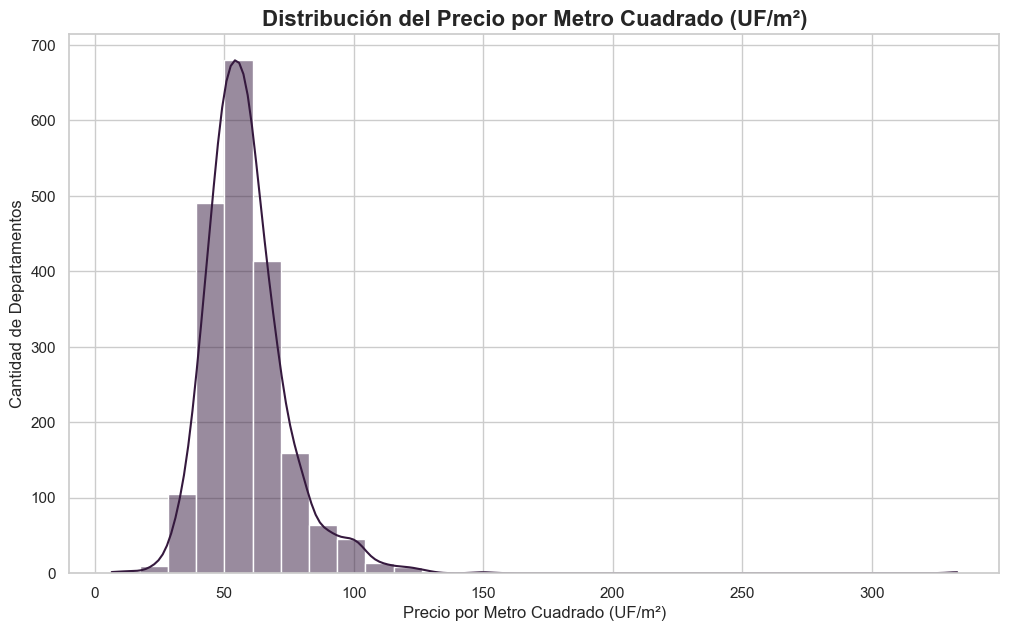

In [102]:
# Configuramos el tema y el tamaño del gráfico
sns.set_theme(style="whitegrid", palette="rocket")
plt.figure(figsize=(12, 7))

# Creamos el histograma para nuestra nueva métrica
sns.histplot(data=df_final, x='Precio_por_m2', kde=True, bins=30)

# Añadimos títulos y etiquetas
plt.title('Distribución del Precio por Metro Cuadrado (UF/m²)', fontsize=16, weight='bold')
plt.xlabel('Precio por Metro Cuadrado (UF/m²)', fontsize=12)
plt.ylabel('Cantidad de Departamentos', fontsize=12)

# Mostramos el gráfico
plt.show()

La gran mayoría de los departamentos se concentra en un rango de valor entre 50 y 80 UF/m², indicando un mercado relativamente consistente en términos de costo por espacio.

#### Mapa de calor de correlación
Para visualizar la relación entre las variables en búsqueda de las características que mas podrían influenciar en el `Precio`.

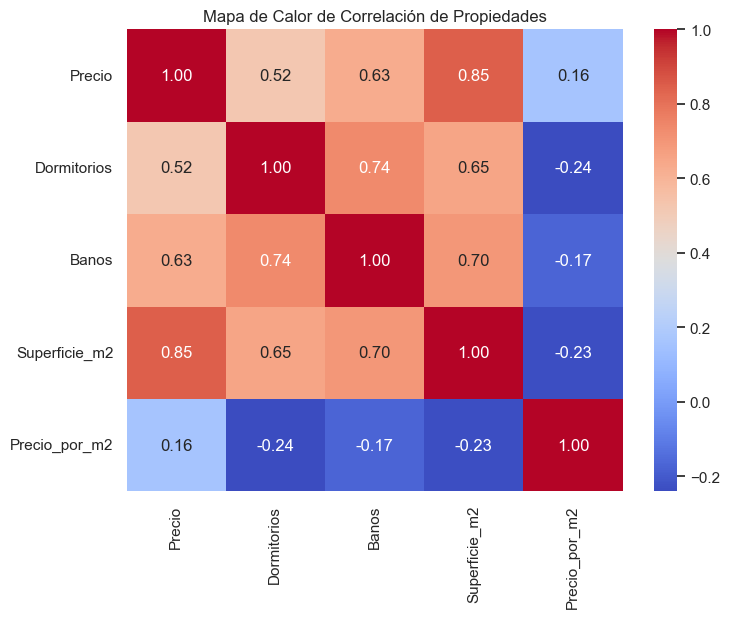

In [103]:
# Calculamos la matriz de correlación del DataFrame
corr_matrix = df_final.corr()

# Creamos la figura y los ejes para el gráfico
plt.figure(figsize=(8, 6))

# Creamos el mapa de calor usando Seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f') 

# Añadimos un título
plt.title('Mapa de Calor de Correlación de Propiedades')

# Mostramos el gráfico
plt.show()

La correlación más alta con el `Precio`, obviamente con los pocos datos que manejamos, es la `Superficie_m2`, con un valor muy fuerte de 0.85.

Este hallazgo indica que el tamaño del departamento es, por lejos, el factor que más influye en su valor. A medida que los metros cuadrados aumentan, el precio tiende a subir de una manera muy predecible. Confirmando así la lógica del mercado inmobiliario.

#### ¿Cuál es el precio promedio, mínimo y máximo de un departamento en Santiago?

In [110]:
# Calculamos cada estadística individualmente
precio_promedio = df_final['Precio'].mean()
precio_minimo = df_final['Precio'].min()
precio_maximo = df_final['Precio'].max()

# Usamos f-strings para imprimir los resultados formateados
print(f"\nPrecio Promedio: {precio_promedio:,.0f} UF")
print(f"Precio Mínimo: {precio_minimo:,.0f} UF")
print(f"Precio Máximo: {precio_maximo:,.0f} UF")


Precio Promedio: 2,801 UF
Precio Mínimo: 383 UF
Precio Máximo: 23,500 UF


#### ¿Cuál es la superficie promedio?

In [105]:
# Calculamos el promedio (media) de la columna 'Superficie_m2'
superficie_promedio = df_final['Superficie_m2'].mean()

# Imprimimos el resultado formateado con dos decimales
print(f"La superficie promedio de los departamentos es: {superficie_promedio:.2f} m²")

La superficie promedio de los departamentos es: 50.34 m²


#### ¿Cuál es la configuración máscomún (ej. 2 dormitorios, 2 baños)?

In [106]:
# .idxmax() nos da el índice del valor más alto, que en este caso es la tupla (dormitorios, baños) más común.
configuracion_top = df_final.groupby(['Dormitorios', 'Banos']).size().idxmax()

print(f"\nLa configuración más común es: {configuracion_top[0]} dormitorios y {configuracion_top[1]} baños.")


La configuración más común es: 1 dormitorios y 1 baños.


#### ¿La mayoría de los departamentos se concentran en un rango de precios específico?

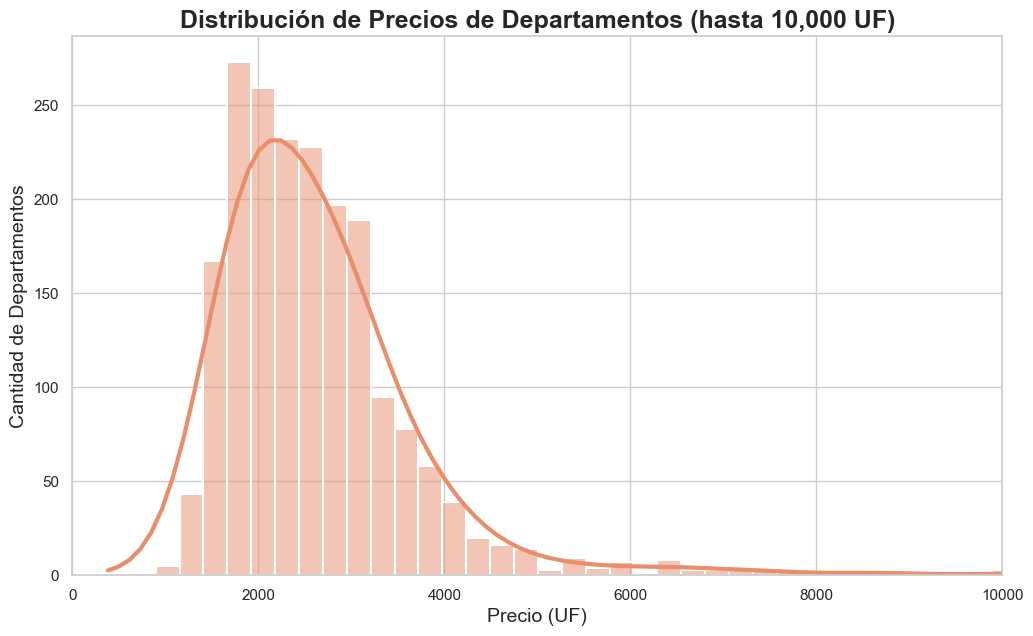

In [107]:
# Configuramos el tema y la paleta de colores
sns.set_theme(style="whitegrid", palette="flare")

# Creamos la figura
plt.figure(figsize=(12, 7))

# Creamos el histograma
sns.histplot(
    data=df_final,
    x='Precio',
    kde=True,
    edgecolor="white",
    linewidth=1.5,
    line_kws={'linewidth': 3}
)

# Establecemos el límite del eje X para que vaya desde 0 hasta 10000
plt.xlim(0, 10000)

# Añadimos títulos y etiquetas
plt.title('Distribución de Precios de Departamentos (hasta 10,000 UF)', fontsize=18, weight='bold')
plt.xlabel('Precio (UF)', fontsize=14)
plt.ylabel('Cantidad de Departamentos', fontsize=14)

# Mostramos el gráfico
plt.show()

El gráfico muestra que la gran mayoría de los departamentos en venta se concentra en un rango de precios relativamente estrecho, principalmente entre las 1,500 y 3,500 UF. El punto más alto (la moda) se encuentra alrededor de las 2,000 - 2,500 UF.

Distribución con Sesgo Positivo: La distribución no es simétrica. Presenta un sesgo positivo (o "cola a la derecha"), lo cual es típico en datos de ingresos o precios. Esto significa que, si bien la mayoría de las propiedades son relativamente asequibles, existe un número menor de departamentos con precios mucho más altos que "estiran" la distribución hacia la derecha.

#### ¿Cómo se compara la distribución de precios entre las diferentes cantidades de dormitorios?

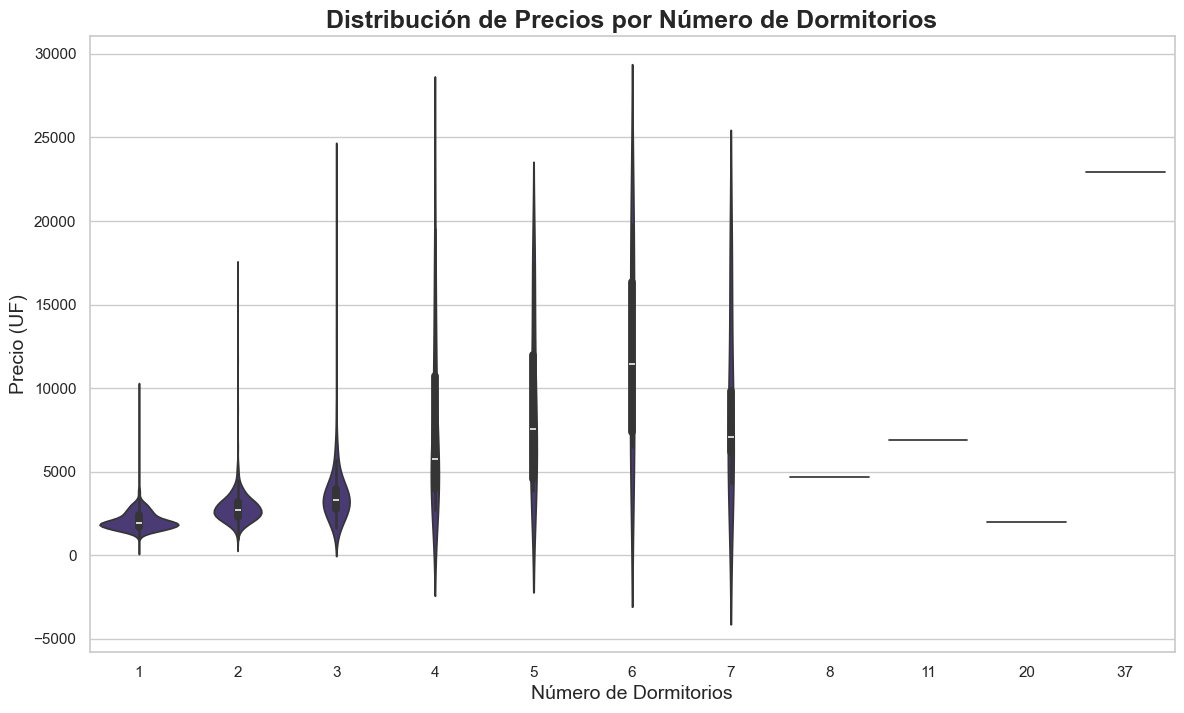

In [108]:
# Configuramos el tema y el tamaño del gráfico
sns.set_theme(style="whitegrid", palette="viridis")
plt.figure(figsize=(14, 8))

# Creamos el gráfico de violín
# 'x' será la categoría (Dormitorios) y 'y' la variable numérica (Precio)
sns.violinplot(
    data=df_final,
    x='Dormitorios',
    y='Precio'
)

# Añadimos títulos y etiquetas para mayor claridad
plt.title('Distribución de Precios por Número de Dormitorios', fontsize=18, weight='bold')
plt.xlabel('Número de Dormitorios', fontsize=14)
plt.ylabel('Precio (UF)', fontsize=14)

# Mostramos el gráfico
plt.show()

La mayor parte de la oferta se concentra en departamentos de 1, 2 y 3 dormitorios. Esto se evidencia en que los violines de estas categorías son los más anchos en la base, indicando una alta densidad de propiedades en los rangos de precios más bajos.

A medida que aumenta el número de dormitorios, se observa una clara tendencia al alza en el precio mediano (el punto blanco). Además, los violines se alargan, lo que significa que aumenta la variabilidad: el rango de precios para un departamento de 4 dormitorios es mucho más amplio que para uno de 1 dormitorio.

Las propiedades con 8 o más dormitorios son casos atípicos y muy escasos en el conjunto de datos. Sus gráficos son extremadamente delgados o simplemente líneas, lo que indica que hay muy pocas propiedades en estas categorías, representando un nicho de mercado muy específico.

#### ¿Cómo afecta la superficie al precio? ¿Más metros cuadrados, siempre sube el precio?

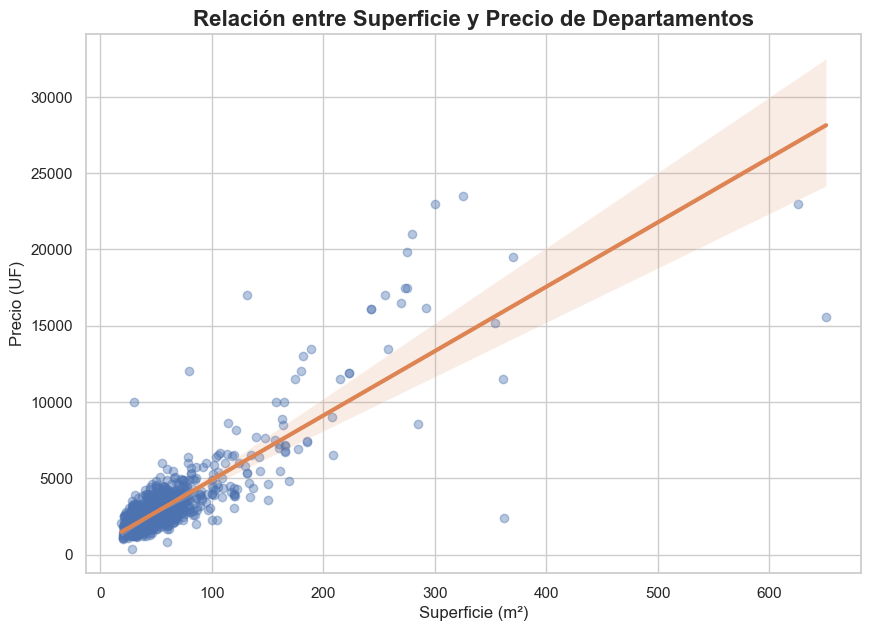

In [109]:
# Configuramos el tema y el tamaño del gráfico
sns.set_theme(style="whitegrid") # Estilo de fondo blanco con cuadrícula
plt.figure(figsize=(10, 7)) # Tamaño del gráfico

# Creamos un gráfico de dispersión con una línea de regresión para ver la tendencia
sns.regplot(
    data=df_final, 
    x='Superficie_m2', 
    y='Precio',
    scatter_kws={'alpha':0.4, 'color':'#4C72B0'}, # Hacemos los puntos semitransparentes
    line_kws={'color':'#DD8452', 'linewidth':3} # Hacemos la línea de tendencia más gruesa y de otro color
)

# Añadimos títulos y etiquetas
plt.title('Relación entre Superficie y Precio de Departamentos', fontsize=16, weight='bold')
plt.xlabel('Superficie (m²)', fontsize=12)
plt.ylabel('Precio (UF)', fontsize=12)

# Mostramos el gráfico
plt.show()

Se observa una clara tendencia ascendente. A medida que aumenta la Superficie (m²), el Precio (UF) también tiende a aumentar de forma predecible, tal como lo indica la línea de regresión.

Tambien podemos ver que a medida que la superficie crece, los puntos se dispersan más, lo que indica una mayor variabilidad de precios en las propiedades más grandes.

La mayoría de los puntos se agrupan en la esquina inferior izquierda, confirmando que el grueso del mercado se encuentra en departamentos de menos de 200 m² y precios por debajo de las 10,000 UF.